## Setup

In [2]:
from pathlib import Path
from skimage import io
import numpy as np
import napari
from os.path import exists
from brainlit.utils.session import NeuroglancerSession
from cloudvolume.exceptions import SkeletonDecodeError
from napari_animation import AnimationWidget
from cloudvolume import CloudVolume
from brainlit.utils import NeuronTrace
from pynufft import NUFFT
from tqdm import tqdm

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib widget


dir = "precomputed://s3://open-neurodata/brainlit/brain1"
dir_segments = "precomputed://s3://open-neurodata/brainlit/brain1_segments"
mip = 0
vol = CloudVolume(dir_segments, mip=mip)

num_goal = 0
num = -1
skel_id = -1

while num < num_goal:
    skel_id += 1
    try:
        skel = vol.skeleton.get(skel_id)
        print(f"Skeleton # {skel_id} exists")
        num += 1
    except SkeletonDecodeError:
        print(f"#{skel_id} invalid")

neuron = NeuronTrace(dir_segments, seg_id=skel_id, mip=mip, rounding=False)

paths = neuron.get_paths()  # coordinates are in nm

#0 invalid
#1 invalid
Skeleton # 2 exists


## Aliasing plot

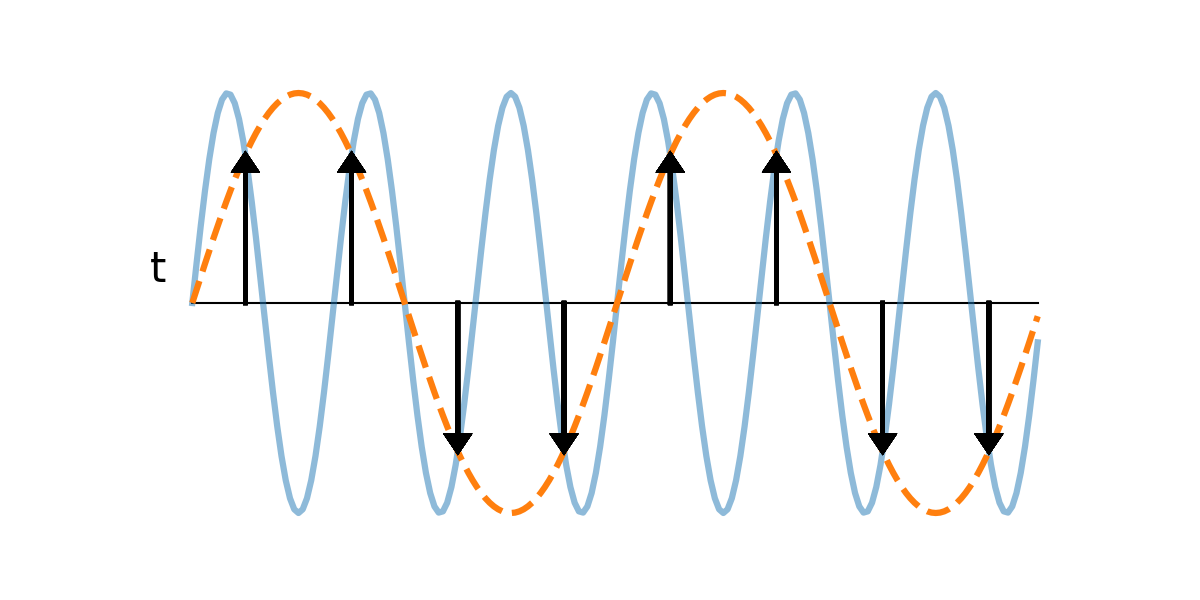

In [3]:
from scipy.optimize import fsolve

ts = np.arange(0, 2, 0.01)


def f1(ts):
    return np.sin(2 * np.pi * ts)


def f2(ts):
    return np.sin(3 * 2 * np.pi * ts)


def f3(ts):
    return f1(ts) - f2(ts)


fig, ax = plt.subplots(1, 1, figsize=(4, 2), dpi=300)
ax.plot([ts[0], ts[-1]], [0, 0], color="black", linewidth=0.5, zorder=1)
ax.plot(ts, f2(ts), alpha=0.5, zorder=2)
ax.plot(ts, f1(ts), linestyle="--", zorder=3)
ax.axis("off")
ax.text(-0.1, 0.1, "t")


zeros = []
for t in ts:
    soln = fsolve(f3, t)[0]
    add = True
    for zero in zeros:
        if np.abs(zero - soln) < 0.01:
            add = False
            break

    if add and soln > 0 and soln < 2 and np.abs(f1(soln)) > 0.01:
        ax.arrow(
            soln,
            0,
            0,
            f1(soln),
            head_width=0.05,
            length_includes_head=True,
            color="black",
            zorder=4,
        )

## Plot neuron

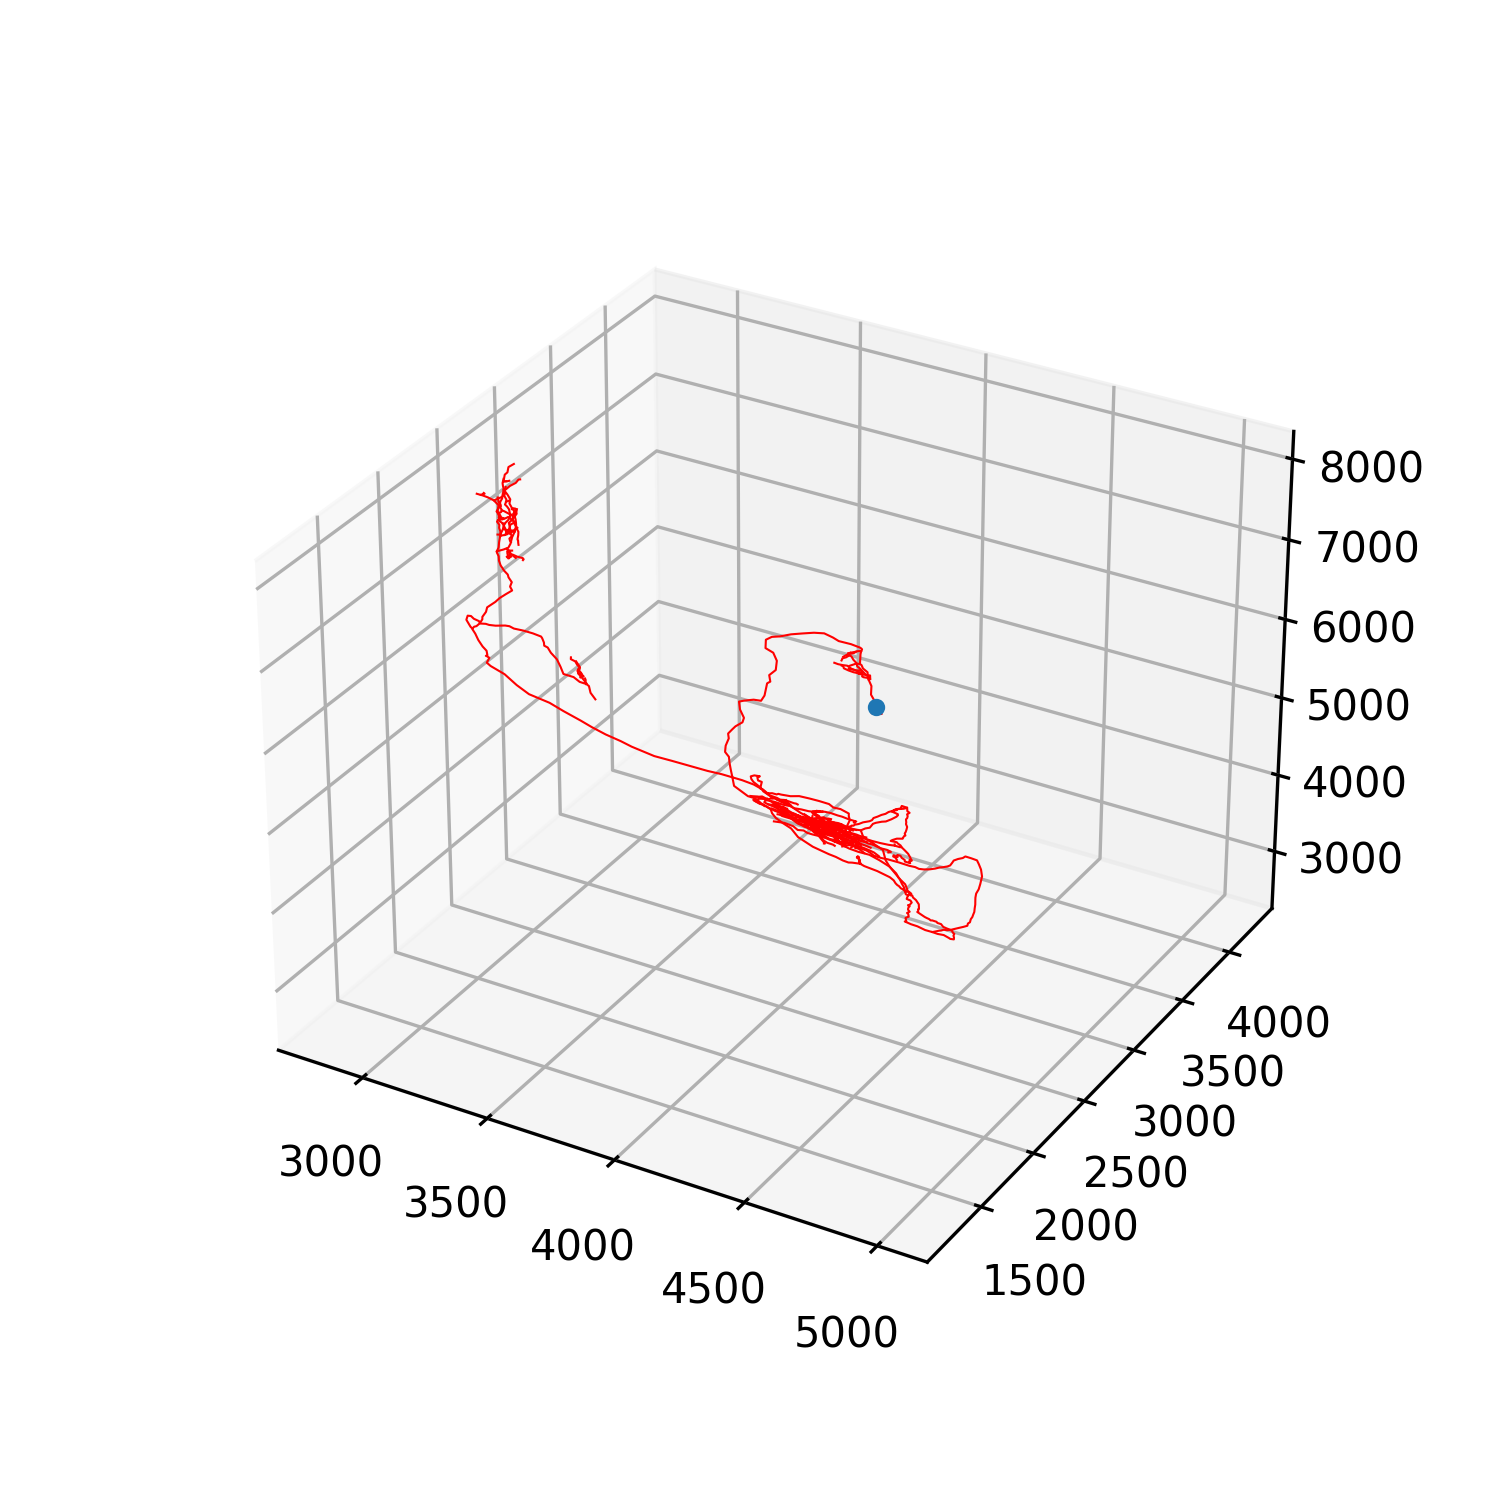

In [4]:
fig = plt.figure(figsize=(5, 5), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection="3d")

soma = neuron.df.iloc[0]

for path in paths:
    path2 = path / 1000
    ax.plot(path2[:, 0], path2[:, 1], path2[:, 2], color="red", linewidth=0.5)
ax.scatter(soma["x"] / 1000, soma["y"] / 1000, soma["z"] / 1000, s=10)

## Average sample distance plot

In [10]:
neuron_ids = []
periods = []


for num_goal in tqdm(range(50), desc="processing neurons"):
    num = -1
    skel_id = -1
    while num < num_goal:
        skel_id += 1
        try:
            skel = vol.skeleton.get(skel_id)
            num += 1
        except SkeletonDecodeError:
            pass

    
    neuron_ids.append(skel_id)

    neuron = NeuronTrace(dir_segments, seg_id=skel_id, mip=mip, rounding=False)

    paths = neuron.get_paths()  # coordinates are in nm

    for path_n, path in enumerate(
        tqdm(paths, desc="Looping through paths", leave=False)
    ):
        diffs = np.diff(path, axis=0)
        norms = np.linalg.norm(diffs, axis=1)/1000
        periods += list(norms)
        

print(f"{len(periods)} total segments across {len(neuron_ids)} neurons")

data = {
    "Space Between Sample Points (microns)": periods,
}
df = pd.DataFrame(data=data)



processing neurons: 100%|██████████| 50/50 [04:50<00:00,  5.82s/it]

93921 total segments across 50 neurons


Average distance: 24.37485833129674


<AxesSubplot:xlabel='Space Between Sample Points (microns)', ylabel='Count'>

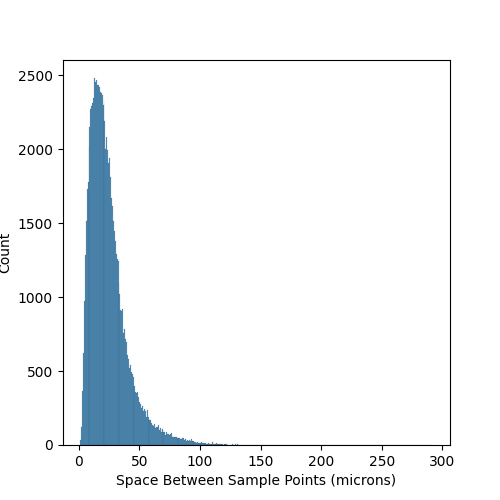

In [14]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
print(f"Average distance: {np.mean(periods)}")
sns.histplot(data=df, x="Space Between Sample Points (microns)", ax=ax)

## Plot cosine approximation

processing neurons:   2%|▏         | 1/50 [00:07<05:56,  7.28s/it]


KeyboardInterrupt: 

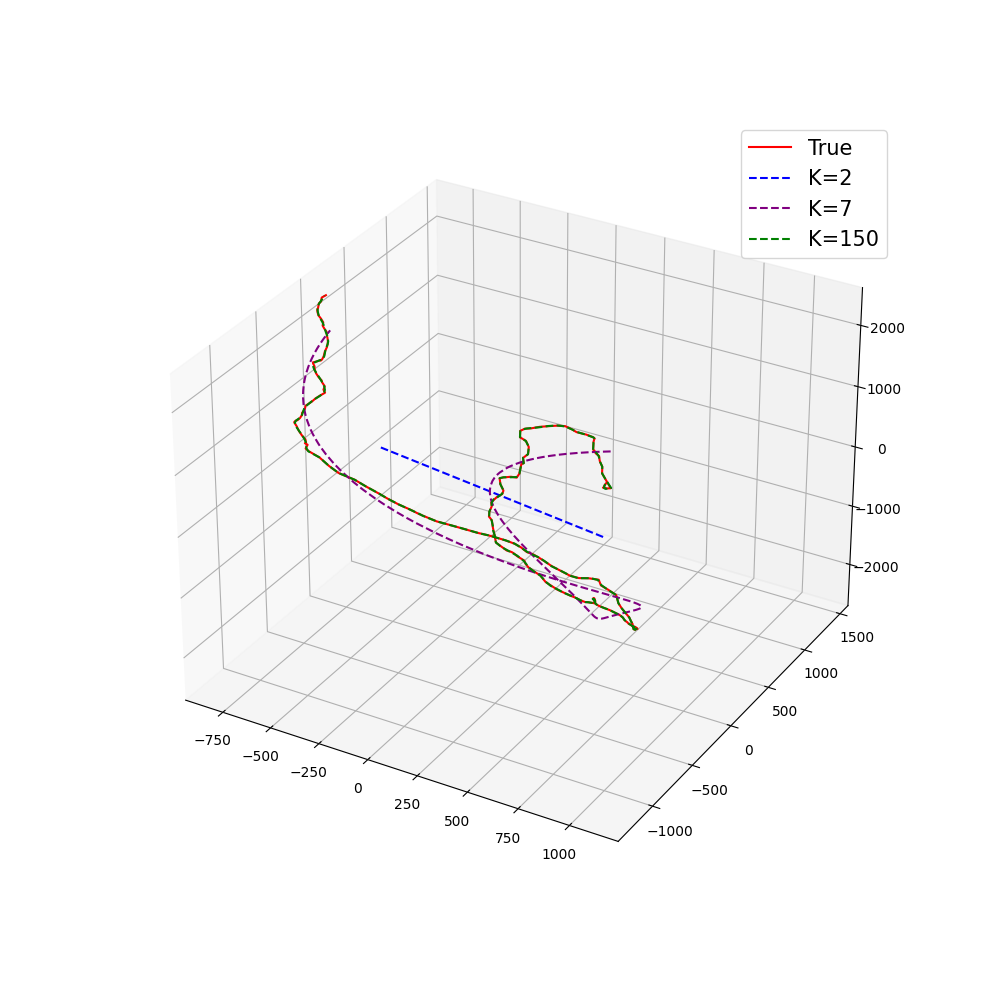

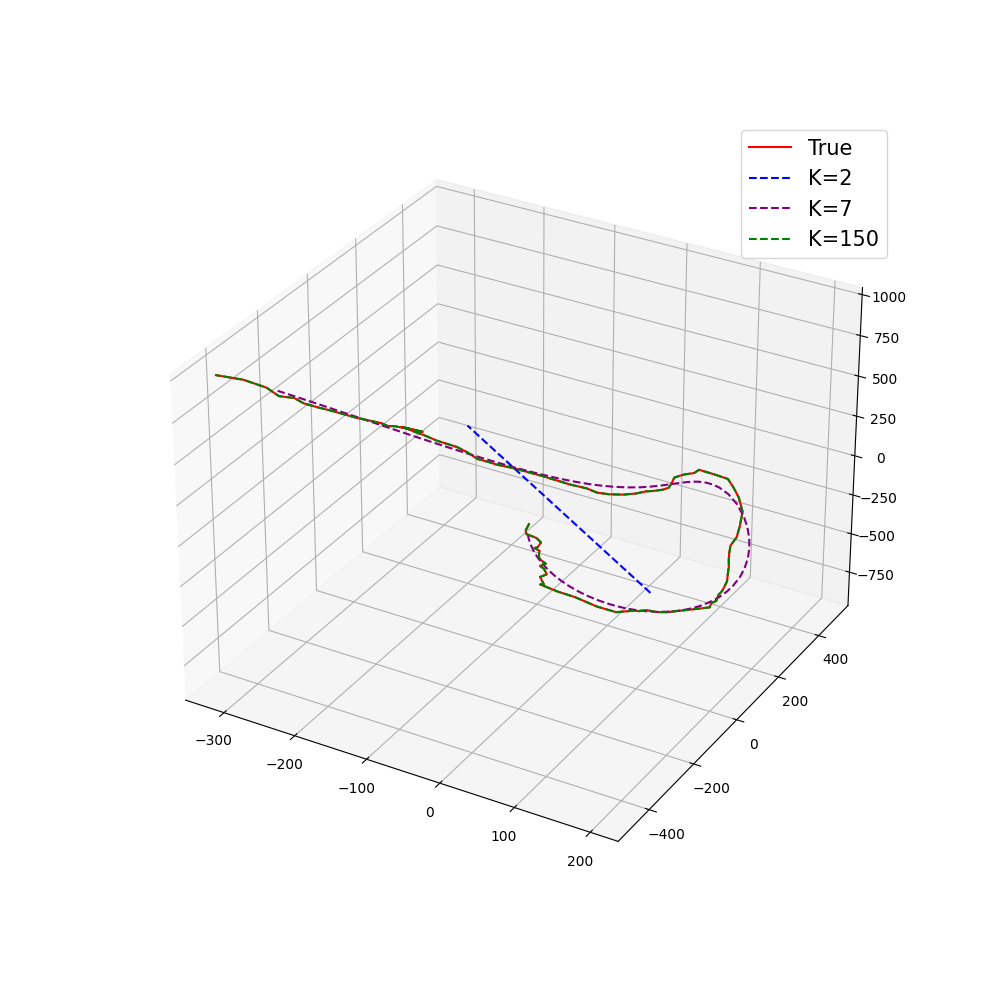

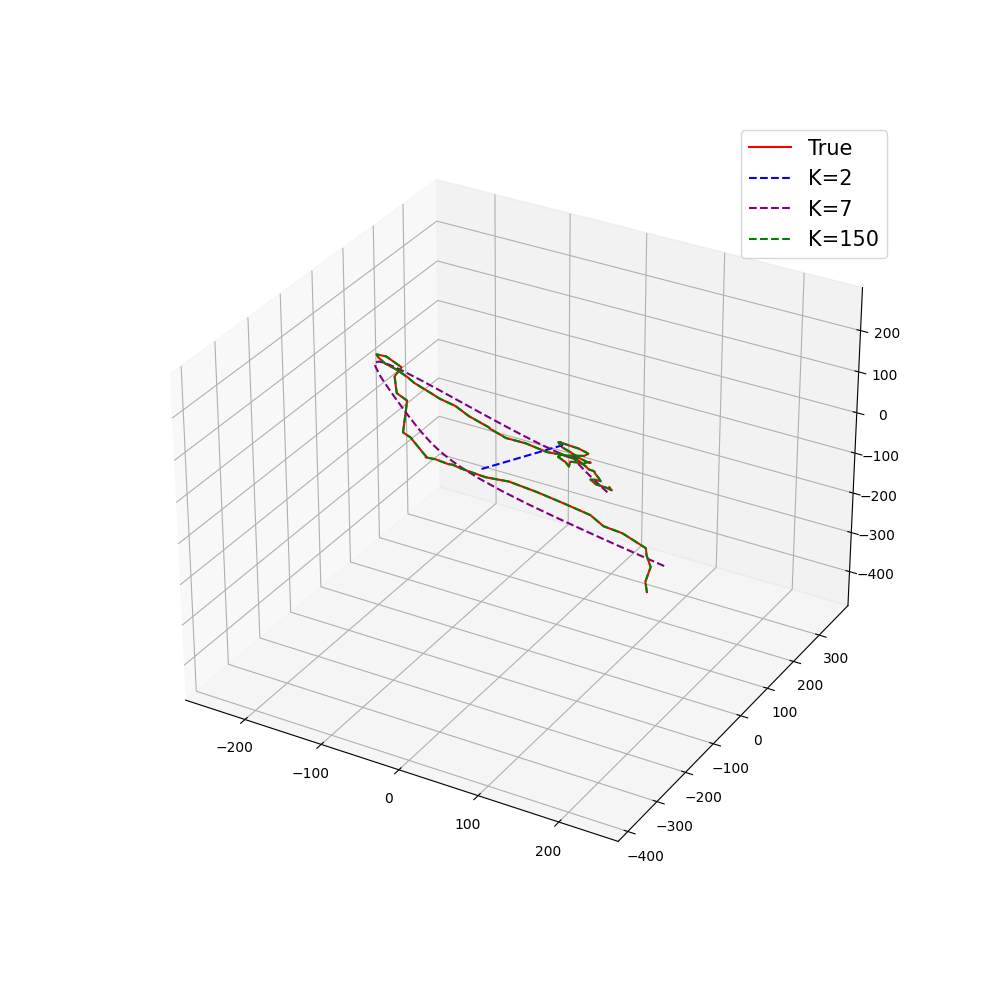

In [5]:
max_k = 150
error_thresh = 1

ks_below_thresh = []
counter = 0

branch_ids = []
av_errors = []
freqs = []

for num_goal in tqdm(range(50), desc="processing neurons"):
    num = -1
    skel_id = -1
    while num < num_goal:
        skel_id += 1
        try:
            skel = vol.skeleton.get(skel_id)
            num += 1
        except SkeletonDecodeError:
            pass

    neuron = NeuronTrace(dir_segments, seg_id=skel_id, mip=mip, rounding=False)

    paths = neuron.get_paths()  # coordinates are in nm

    for path_n, path in enumerate(
        tqdm(paths, desc="Looping through paths", leave=False)
    ):
        diffs = np.diff(path, axis=0)
        norms = np.linalg.norm(diffs, axis=1)
        norms = np.concatenate(([0], norms))
        
        ts = np.cumsum(norms) / 1000
        if ts[-1] < 10 * np.pi:
            continue
        counter += 1
        # ts = ts / ts[-1]

        Y = path / 1000
        Y -= np.mean(Y, axis=0)

        k = np.amin([path.shape[0] * 2, max_k])

        Psi = np.ones((len(ts), k))

        for l in range(1, k):
            col = np.sqrt(2) * np.cos(l * np.pi * ts / ts[-1])
            Psi[:, l] = col

        C_hat = np.linalg.pinv(Psi) @ Y
        Y_hat = Psi @ C_hat

        # show neurons
        if num_goal == 0 and path_n < 3:
            fig_neuron = plt.figure(figsize=(10, 10))
            ax_neuron = plt.axes(projection="3d")
            ax_neuron.plot3D(Y[:, 0], Y[:, 1], Y[:, 2], label="True", color="red")

            for l, c in zip(range(2, np.amin([10, k]), 5), ["blue", "purple", "pink"]):
                C_hat_l = np.linalg.pinv(Psi[:, :l]) @ Y
                Y_hat_l = Psi[:, :l] @ C_hat_l
                ax_neuron.plot3D(
                    Y_hat_l[:, 0],
                    Y_hat_l[:, 1],
                    Y_hat_l[:, 2],
                    label=f"K={l}",
                    linestyle="dashed",
                    color=c,
                )

            ax_neuron.plot3D(
                Y_hat[:, 0],
                Y_hat[:, 1],
                Y_hat[:, 2],
                label=f"K={k}",
                linestyle="dashed",
                color="green",
            )

            ax_neuron.legend(fontsize=15)

        # look at goodness of fit (coefficients or rmsqe)
        Cs = np.abs(C_hat) ** 2

        averr_branch = []
        for l in range(k):
            C_hat = np.linalg.pinv(Psi[:, :l]) @ Y
            Y_hat_l = Psi[:, :l] @ C_hat[:l, :]
            av_error = np.mean(np.linalg.norm((Y - Y_hat_l), axis=1))
            averr_branch.append(av_error)
            av_errors.append(av_error)
            freqs.append(l * np.pi / ts[-1])
            branch_ids.append(counter)

        averr_branch = np.array(averr_branch)
        where = np.argwhere(averr_branch < error_thresh)
        if np.sum(where) == 0:
            pass
            # print(
            #     f"{path_n} path error does not fall below {error_thresh} min error: {np.amin(averr, axis=0)}, max freq: {k*np.pi/ts[-1]}"
            # )
            # print(np.amin(averr_branch, axis=0))
        else:
            idx = np.amin(where) / (ts[-1] * 2)
            ks_below_thresh.append(idx)


print(f"{len(ks_below_thresh)}/{counter} achieve error below {error_thresh}")

data = {
    "Average Error at Trace Points (microns)": av_errors,
    "Highest Frequency Term (rad/micron)": freqs,
    "Branches": branch_ids,
}
df = pd.DataFrame(data=data)

## Error vs frequency plot

In [ ]:
fig_coeffs, ax_coeffs = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
lineplt = sns.lineplot(
    data=df,
    x="Highest Frequency Term (rad/micron)",
    y="Average Error at Trace Points (microns)",
    hue="Branches",
    ax=ax_coeffs,
    palette="tab20",
    linewidth=0.5,
    legend=False,
)
lineplt.set(yscale="log")

ax_coeffs.set_xlim([0, 0.5])
ax_coeffs.set_ylim([10**0, 10**3])
# ax_coeffs.set_title("Error vs. Frequency Components for 6176 Neuron Branches", fontsize=10, pad=10)

### Frequency box plot

In [ ]:
fig_ks = plt.figure(figsize=(10, 5))
ax_ks = plt.axes()
data = {
    "Maximum Frequency to Achieve < 1 micron Average Error (revolutions per micron)": ks_below_thresh
}
df = pd.DataFrame(data)
sns.set_theme(style="whitegrid")
sns.stripplot(
    x="Maximum Frequency to Achieve < 1 micron Average Error (revolutions per micron)",
    ax=ax_ks,
    data=df,
    alpha=0.1,
)
sns.boxplot(
    x="Maximum Frequency to Achieve < 1 micron Average Error (revolutions per micron)",
    ax=ax_ks,
    data=df,
)
# plt.title(f"Approximate Bandwidth of {counter} Axon Branches")
plt.show()

for i in range(counter - len(ks_below_thresh)):
    ks_below_thresh.append(np.infty)
print(f"99th percentile frequency: {np.percentile(ks_below_thresh, 99)}")